# Introduction

In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image

# Tiny ImageNet Dataset

Dataset website: [Tiny ImageNet Visual Recognition Challenge](https://tiny-imagenet.herokuapp.com/)

**Download and Extract**

In [2]:
def download(url, path, md5sum):
    import os
    import urllib
    import hashlib

    folder, file = os.path.split(path)
    if folder != '':
        os.makedirs(folder, exist_ok=True)
    if not os.path.isfile(path):
        print('Downloading', path, '...')
        urllib.request.urlretrieve(url, path)
        assert hashlib.md5(open(path, 'rb').read()).hexdigest() == md5sum
    else:
        assert hashlib.md5(open(path, 'rb').read()).hexdigest() == md5sum
        print('Already Exists:', file)

In [3]:
download('http://cs231n.stanford.edu/tiny-imagenet-200.zip',
        path='./tiny-imagenet/tiny-imagenet-200.zip', md5sum='90528d7ca1a48142e341f4ef8d21d0de')

Already Exists: tiny-imagenet-200.zip


In [5]:
def extract(filepath):
    import zipfile
    import os

    path, file = os.path.split(filepath)

    extract_path, _ = os.path.splitext(filepath)
    already_extracted = os.path.isdir(extract_path)
    if not already_extracted:
        with zipfile.ZipFile(filepath, 'r') as zf:
            print('Extracting', file, '...')
            zf.extractall(path)
    else:
        print('Already Extracted:', file)
        
    assert os.path.isdir(extract_path)

In [6]:
extract('./tiny-imagenet/tiny-imagenet-200.zip')

Already Extracted: tiny-imagenet-200.zip


**Load Train Data**

In [6]:
datafolder = './tiny-imagenet/tiny-imagenet-200'
datafolder

'../Datasets/tiny-imagenet/tiny-imagenet-200'

In [7]:
trainfolder = os.path.join(datafolder, 'train')
trainfolder

'../Datasets/tiny-imagenet/tiny-imagenet-200/train'

In [8]:
x_train = []
y_train_raw = []
for img_path in sorted(pathlib.Path(trainfolder).rglob('*.JPEG')):
    img = matplotlib.image.imread(img_path)
    if len(img.shape) == 2:
        img = np.stack([img, img, img], axis=-1)
    x_train.append(img)
    y_train_raw.append(img_path.name.split('_')[0])
x_train = np.array(x_train)
y_train_raw = np.array(y_train_raw)

In [9]:
assert x_train.shape == (100000, 64, 64, 3)
assert x_train.min() == 0
assert x_train.max() == 255
assert len(set(y_train_raw)) == 200

Show example

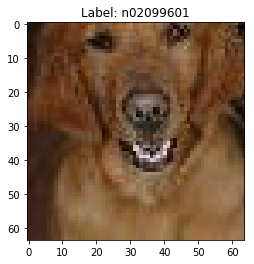

In [10]:
idx = 13237
plt.imshow(x_train[idx])
plt.title('Label: '+y_train_raw[idx]);

**Load Validation Set**

In [11]:
valfolder = os.path.join(datafolder, 'val')
valfolder

'../Datasets/tiny-imagenet/tiny-imagenet-200/val'

In [12]:
val_annotations = np.loadtxt(os.path.join(valfolder, 'val_annotations.txt'), dtype=str, delimiter='\t')
val_annotations

array([['val_0.JPEG', 'n03444034', '0', '32', '44', '62'],
       ['val_1.JPEG', 'n04067472', '52', '55', '57', '59'],
       ['val_2.JPEG', 'n04070727', '4', '0', '60', '55'],
       ...,
       ['val_9997.JPEG', 'n03424325', '10', '10', '38', '42'],
       ['val_9998.JPEG', 'n01629819', '28', '18', '63', '31'],
       ['val_9999.JPEG', 'n02699494', '17', '33', '28', '39']],
      dtype='<U13')

In [13]:
valimg_to_classid_dir = {valimg: classid for valimg, classid, _, _, _, _ in val_annotations}
for i, (k, v) in enumerate(valimg_to_classid_dir.items()):
    print(k, ' -> ', v)
    if i >= 4: break

val_0.JPEG  ->  n03444034
val_1.JPEG  ->  n04067472
val_2.JPEG  ->  n04070727
val_3.JPEG  ->  n02808440
val_4.JPEG  ->  n02808440


In [14]:
x_valid = []
y_valid_raw = []
for img_path in sorted(pathlib.Path(valfolder).rglob('*.JPEG')):
    img = matplotlib.image.imread(img_path)
    if len(img.shape) == 2:
        img = np.stack([img, img, img], axis=-1)
    x_valid.append(img)
    y_valid_raw.append(valimg_to_classid_dir[img_path.name])
x_valid = np.array(x_valid)
y_valid_raw = np.array(y_valid_raw)

In [15]:
assert x_valid.shape == (10000, 64, 64, 3)
assert x_valid.min() == 0
assert x_valid.max() == 255
assert len(set(y_valid_raw)) == 200         # should be 200 distinct classes in validation set

**Convert Labels to Integers**

Get all unique labels

In [16]:
unique_labels = set(y_train_raw)

Create dictionaries for converting labels to ints and vice-versa.

In [17]:
label_to_idx = {label : i for i, label in enumerate(sorted(unique_labels))}
idx_to_label = {i : label for label, i in label_to_idx.items()}
for label, idx in label_to_idx.items():
    assert idx_to_label[label_to_idx[label]] == label

In [18]:
y_train = [label_to_idx[y] for y in y_train_raw]
for i in range(len(y_train_raw)):
    assert idx_to_label[y_train[i]] == y_train_raw[i]

In [19]:
y_valid = [label_to_idx[y] for y in y_valid_raw]
for i in range(len(y_valid_raw)):
    assert idx_to_label[y_valid[i]] == y_valid_raw[i]

**Create Tag Dictionary**

File 'words.txt' contains mapping of labels into human readable tags. There are multiple tags for some labels, we will save only first one

In [21]:
words_txt = np.loadtxt(os.path.join(datafolder, 'words.txt'), dtype=str, delimiter='\t')
words_txt

array([['n00001740', 'entity'],
       ['n00001930', 'physical entity'],
       ['n00002137', 'abstraction, abstract entity'],
       ...,
       ['n15299585', 'usance'],
       ['n15299783', 'window'],
       ['n15300051', '9/11, 9-11, September 11, Sept. 11, Sep 11']],
      dtype='<U218')

In [22]:
labels_to_tags = {label: tags.split(',')[0] for label, tags in words_txt if label in unique_labels}
print('n01443537 ->', labels_to_tags['n01443537'])
print('n01770393 ->', labels_to_tags['n01770393'])
print('n01945685 ->', labels_to_tags['n01945685'])

n01443537 -> goldfish
n01770393 -> scorpion
n01945685 -> slug


In [26]:
idx_to_tags = {label_to_idx[label] : labels_to_tags[label] for label in sorted(unique_labels)}

**Save to .npz**

In [36]:
save_path = './tiny-imagenet/tiny-imagenet-200.npz'
save_path

'../Datasets/tiny-imagenet/tiny-imagenet-200.npz'

In [37]:
np.savez(save_path,
         x_train=x_train,
         y_train=y_train,
         x_valid=x_valid,
         y_valid=y_valid,
         idx_to_tags=idx_to_tags)

**Test .npz ok**

In [38]:
npzfile = np.load(save_path)

In [39]:
npzfile.files

['x_train', 'y_train', 'x_valid', 'y_valid', 'idx_to_tags']

In [40]:
x_train_2 = npzfile['x_train']
y_train_2 = npzfile['y_train']
x_valid_2 = npzfile['x_valid']
y_valid_2 = npzfile['y_valid']
idx_to_tags_2 = npzfile['idx_to_tags']

In [41]:
assert np.alltrue(x_train == x_train_2)
assert np.alltrue(y_train == y_train_2)
assert np.alltrue(x_valid == x_valid_2)
assert np.alltrue(y_valid == y_valid_2)
assert np.alltrue(idx_to_tags == idx_to_tags_2)